In [135]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [136]:
# set the first column is target 
# ab_path='../data/S50-Daily-Nov20_-Now.csv'
ab_path='../data/SPY-Daily-Y09-Now.csv'

start_date='2020-01-01'
end_date='2022-12-31'

#This sample is allow you to set 1 lokback and 1 step forwad
time_step_predict=22  
predict_ahead=1


ratio_train=0.8

feature_cols=['EMA1']
predict_ahead=1

# load data

In [137]:
dataset=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
dataset.rename(columns={'Date/Time':'DateTime'},inplace=True)
dataset=dataset.sort_values('DateTime')

dataset.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3505 entries, 0 to 3504
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Ticker    3505 non-null   object        
 1   DateTime  3505 non-null   datetime64[ns]
 2   Price     3505 non-null   float64       
 3   EMA1      3505 non-null   float64       
 4   EMA2      3505 non-null   float64       
 5   EMA3      3505 non-null   float64       
 6   MACD      3505 non-null   float64       
 7   SIGNAL    3505 non-null   float64       
 8   RSI       3505 non-null   float64       
 9   RSI-MA    3505 non-null   float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 301.2+ KB


# Filter Only Data to train and test

In [138]:
dataset=dataset.query("DateTime>=@start_date and DateTime<=@end_date")
dataset=dataset.reset_index(drop=True)

dt_df=dataset[['DateTime']]
dt_df=dt_df.reset_index(drop=True)

print(f"{dt_df['DateTime'].min()} - {dt_df['DateTime'].max()}")
dataset.info()


2020-01-02 00:00:00 - 2022-12-02 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Ticker    737 non-null    object        
 1   DateTime  737 non-null    datetime64[ns]
 2   Price     737 non-null    float64       
 3   EMA1      737 non-null    float64       
 4   EMA2      737 non-null    float64       
 5   EMA3      737 non-null    float64       
 6   MACD      737 non-null    float64       
 7   SIGNAL    737 non-null    float64       
 8   RSI       737 non-null    float64       
 9   RSI-MA    737 non-null    float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 57.7+ KB


# Select ColumnFeature

# Most importance for this script : The first Column is Target to predict  and feature

In [139]:
#dataset.drop(columns=['Ticker','DateTime'],inplace=True)

dataset=dataset[feature_cols]
print(dataset.info())

featureList=dataset.columns.tolist()
num_cols=len(featureList)
print(f"The features include target = {num_cols} such as {featureList}")
print(f"Target at the first column of feature list is {featureList[0]}")

dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    737 non-null    float64
dtypes: float64(1)
memory usage: 5.9 KB
None
The features include target = 1 such as ['EMA1']
Target at the first column of feature list is EMA1


,EMA1
0,321.50
1,321.67
2,322.02
3,322.15
4,322.57


# Get Numpy Values

In [140]:
values = dataset.values
# integer encode direction
values = values.astype('float32')
print(values[:3])
print(values.shape)

[[321.5 ]
 [321.67]
 [322.02]]
(737, 1)


[0]


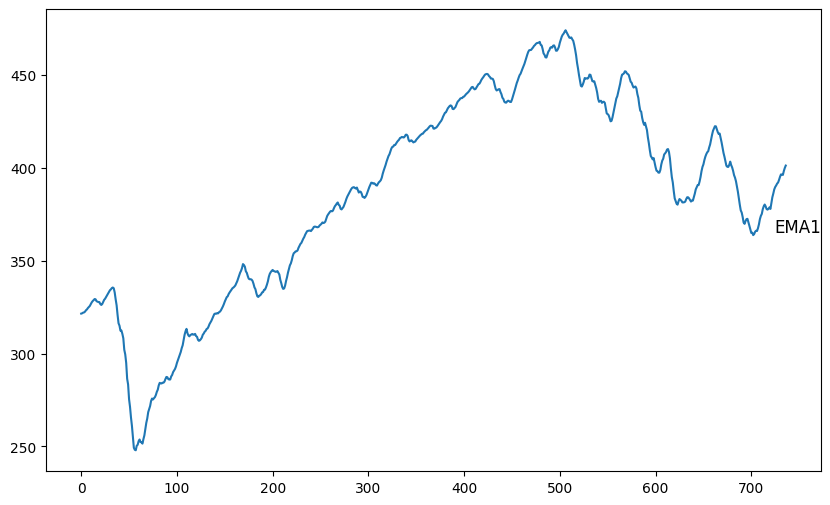

In [141]:

groups =list(range(0,num_cols))
print(groups)
# plot each column
def plot_all_data(x_values):
    pyplot.figure(figsize=(10,6))
    i = 1 # for set chart on gifure
    for group in groups:
      pyplot.subplot(len(groups), 1, i)
      pyplot.plot(x_values[:, group]) 
      pyplot.title(dataset.columns[group], y=0.5, loc='right')
      i += 1
    pyplot.show()
    
plot_all_data(values)

# Feature eng Normalize


In [142]:
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler ()
scaled_values = scaler.fit_transform(values)
scaled_values=np.around(scaled_values,decimals=2)
print(scaled_values[:5])
print(scaled_values.shape)

# plot_all_data(scaled_values)

[[0.33]
 [0.33]
 [0.33]
 [0.33]
 [0.33]]
(737, 1)


# Frame as supervised learning

In [143]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

print(f"We gonna take the prior  {time_step_predict} records to predict {predict_ahead} ahead")
reframed = series_to_supervised(scaled_values,time_step_predict , predict_ahead)
print(reframed.info())

print(f"varN(t): {scaled_values[time_step_predict]}") 
reframed.head(time_step_predict)

We gonna take the prior  22 records to predict 1 ahead
<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 22 to 736
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   var1(t-22)  715 non-null    float32
 1   var1(t-21)  715 non-null    float32
 2   var1(t-20)  715 non-null    float32
 3   var1(t-19)  715 non-null    float32
 4   var1(t-18)  715 non-null    float32
 5   var1(t-17)  715 non-null    float32
 6   var1(t-16)  715 non-null    float32
 7   var1(t-15)  715 non-null    float32
 8   var1(t-14)  715 non-null    float32
 9   var1(t-13)  715 non-null    float32
 10  var1(t-12)  715 non-null    float32
 11  var1(t-11)  715 non-null    float32
 12  var1(t-10)  715 non-null    float32
 13  var1(t-9)   715 non-null    float32
 14  var1(t-8)   715 non-null    float32
 15  var1(t-7)   715 non-null    float32
 16  var1(t-6)   715 non-null    float32
 17  var1(t-5)   715 non-null    float32
 18  var1(t-4)   71

,var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
22,0.33,0.33,0.33,0.33,0.33,0.33,0.34,0.34,0.34,0.34,...,0.36,0.36,0.36,0.35,0.35,0.35,0.35,0.35,0.35,0.35
23,0.33,0.33,0.33,0.33,0.33,0.34,0.34,0.34,0.34,0.35,...,0.36,0.36,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35
24,0.33,0.33,0.33,0.33,0.34,0.34,0.34,0.34,0.35,0.35,...,0.36,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.36
25,0.33,0.33,0.33,0.34,0.34,0.34,0.34,0.35,0.35,0.36,...,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.36,0.36
26,0.33,0.33,0.34,0.34,0.34,0.34,0.35,0.35,0.36,0.36,...,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.36,0.36,0.37
27,0.33,0.34,0.34,0.34,0.34,0.35,0.35,0.36,0.36,0.36,...,0.35,0.35,0.35,0.35,0.35,0.35,0.36,0.36,0.37,0.37
28,0.34,0.34,0.34,0.34,0.35,0.35,0.36,0.36,0.36,0.36,...,0.35,0.35,0.35,0.35,0.35,0.36,0.36,0.37,0.37,0.37
29,0.34,0.34,0.34,0.35,0.35,0.36,0.36,0.36,0.36,0.35,...,0.35,0.35,0.35,0.35,0.36,0.36,0.37,0.37,0.37,0.38
30,0.34,0.34,0.35,0.35,0.36,0.36,0.36,0.36,0.35,0.35,...,0.35,0.35,0.35,0.36,0.36,0.37,0.37,0.37,0.38,0.38
31,0.34,0.35,0.35,0.36,0.36,0.36,0.36,0.35,0.35,0.35,...,0.35,0.35,0.36,0.36,0.37,0.37,0.37,0.38,0.38,0.38


In [144]:
print("remove unused predicted column")
# list column as predicted value  var2.......

listAllDelete=  [ f'var{n}(t)' for n in  range(2,(num_cols+1))]
print(f"exclude :{listAllDelete} to predict")

remove unused predicted column
exclude :[] to predict


In [145]:
reframed=reframed.drop(columns=listAllDelete, axis=1)
print(reframed.info())
reframed.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 22 to 736
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   var1(t-22)  715 non-null    float32
 1   var1(t-21)  715 non-null    float32
 2   var1(t-20)  715 non-null    float32
 3   var1(t-19)  715 non-null    float32
 4   var1(t-18)  715 non-null    float32
 5   var1(t-17)  715 non-null    float32
 6   var1(t-16)  715 non-null    float32
 7   var1(t-15)  715 non-null    float32
 8   var1(t-14)  715 non-null    float32
 9   var1(t-13)  715 non-null    float32
 10  var1(t-12)  715 non-null    float32
 11  var1(t-11)  715 non-null    float32
 12  var1(t-10)  715 non-null    float32
 13  var1(t-9)   715 non-null    float32
 14  var1(t-8)   715 non-null    float32
 15  var1(t-7)   715 non-null    float32
 16  var1(t-6)   715 non-null    float32
 17  var1(t-5)   715 non-null    float32
 18  var1(t-4)   715 non-null    float32
 19  var1(t-3)   715 non-null    

,var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
22,0.33,0.33,0.33,0.33,0.33,0.33,0.34,0.34,0.34,0.34,...,0.36,0.36,0.36,0.35,0.35,0.35,0.35,0.35,0.35,0.35
23,0.33,0.33,0.33,0.33,0.33,0.34,0.34,0.34,0.34,0.35,...,0.36,0.36,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35
24,0.33,0.33,0.33,0.33,0.34,0.34,0.34,0.34,0.35,0.35,...,0.36,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.36
25,0.33,0.33,0.33,0.34,0.34,0.34,0.34,0.35,0.35,0.36,...,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.36,0.36
26,0.33,0.33,0.34,0.34,0.34,0.34,0.35,0.35,0.36,0.36,...,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.36,0.36,0.37


# split into train and test sets

In [146]:
# split into train and test sets

values = reframed.values
n_train=math.ceil(round(ratio_train*len(reframed),0))
print(f'train : {n_train}')


train = values[:n_train, :]
test = values[n_train:, :]
print(train.shape)
print(test.shape)

train : 572
(572, 23)
(143, 23)


In [147]:
df_dt_test=dt_df.loc[(n_train+time_step_predict):, :] #+1 is to include the first record (no prev ref)
df_dt_test=df_dt_test.reset_index(drop=True)
print(df_dt_test.info())
print(df_dt_test.head(3))
print(df_dt_test.tail(3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  143 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.2 KB
None
    DateTime
0 2022-05-11
1 2022-05-12
2 2022-05-13
      DateTime
140 2022-11-30
141 2022-12-01
142 2022-12-02


In [148]:
# split into input and outputs
train_X, train_y = train[:, :-predict_ahead], train[:, -predict_ahead]
test_X, test_y = test[:, :-predict_ahead], test[:, -predict_ahead]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(572, 22) (572,) (143, 22) (143,)


In [149]:
# reshape input to be 3D [samples, timesteps to train (we just look at next hour var1(t)), features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(572, 1, 22) (572,) (143, 1, 22) (143,)


# Multivariate LSTM Forecast Model


# Define and Fit Model

In [150]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

In [151]:
callback = EarlyStopping(monitor='loss', patience=2)

In [152]:
print(f"input_shape to lstm=({train_X.shape[1]}, {train_X.shape[2]})")

input_shape to lstm=(1, 22)


In [153]:
n_neurons =time_step_predict
#n_neurons = 50

n_epochs=50

n_batch_size=1

In [154]:

# design network
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


Epoch 1/50
572/572 - 3s - loss: 0.0366 - val_loss: 0.0480 - 3s/epoch - 5ms/step
Epoch 2/50
572/572 - 1s - loss: 0.0309 - val_loss: 0.0695 - 834ms/epoch - 1ms/step
Epoch 3/50
572/572 - 1s - loss: 0.0286 - val_loss: 0.0961 - 805ms/epoch - 1ms/step
Epoch 4/50
572/572 - 1s - loss: 0.0335 - val_loss: 0.1307 - 814ms/epoch - 1ms/step
Epoch 5/50
572/572 - 1s - loss: 0.0363 - val_loss: 0.1400 - 814ms/epoch - 1ms/step
Epoch 6/50
572/572 - 1s - loss: 0.0333 - val_loss: 0.1450 - 806ms/epoch - 1ms/step
Epoch 7/50
572/572 - 1s - loss: 0.0336 - val_loss: 0.1393 - 778ms/epoch - 1ms/step
Epoch 8/50
572/572 - 1s - loss: 0.0319 - val_loss: 0.1486 - 812ms/epoch - 1ms/step
Epoch 9/50
572/572 - 1s - loss: 0.0316 - val_loss: 0.1564 - 822ms/epoch - 1ms/step
Epoch 10/50
572/572 - 1s - loss: 0.0304 - val_loss: 0.1503 - 801ms/epoch - 1ms/step
Epoch 11/50
572/572 - 1s - loss: 0.0307 - val_loss: 0.1716 - 799ms/epoch - 1ms/step
Epoch 12/50
572/572 - 1s - loss: 0.0314 - val_loss: 0.1534 - 826ms/epoch - 1ms/step
Epoc

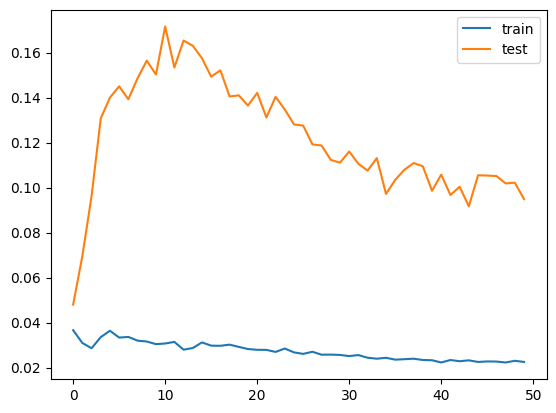

In [155]:
# fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False,callbacks=[callback])
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=n_batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Evaluate Model

# make a prediction

In [156]:

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(yhat[:5])
print(yhat.shape)
print(test_X[:5])
print(test_X.shape)

5/5 [==============================] - 1s 3ms/step
[[0.78788906]
 [0.7810937 ]
 [0.7735583 ]
 [0.7666064 ]
 [0.75898445]]
(143, 1)
[[0.89 0.89 0.88 0.88 0.87 0.86 0.87 0.87 0.86 0.85 0.84 0.82 0.81 0.81
  0.79 0.78 0.77 0.78 0.77 0.76 0.74 0.73]
 [0.89 0.88 0.88 0.87 0.86 0.87 0.87 0.86 0.85 0.84 0.82 0.81 0.81 0.79
  0.78 0.77 0.78 0.77 0.76 0.74 0.73 0.71]
 [0.88 0.88 0.87 0.86 0.87 0.87 0.86 0.85 0.84 0.82 0.81 0.81 0.79 0.78
  0.77 0.78 0.77 0.76 0.74 0.73 0.71 0.7 ]
 [0.88 0.87 0.86 0.87 0.87 0.86 0.85 0.84 0.82 0.81 0.81 0.79 0.78 0.77
  0.78 0.77 0.76 0.74 0.73 0.71 0.7  0.7 ]
 [0.87 0.86 0.87 0.87 0.86 0.85 0.84 0.82 0.81 0.81 0.79 0.78 0.77 0.78
  0.77 0.76 0.74 0.73 0.71 0.7  0.7  0.69]]
(143, 22)


# Concat Target and Feature and InverseTRansform

In [157]:
print("invest scale predicted value")
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
print(inv_yhat.shape)
print(inv_yhat[:5])

invest scale predicted value
(143, 22)
[[0.78788906 0.89       0.88       0.88       0.87       0.86
  0.87       0.87       0.86       0.85       0.84       0.82
  0.81       0.81       0.79       0.78       0.77       0.78
  0.77       0.76       0.74       0.73      ]
 [0.7810937  0.88       0.88       0.87       0.86       0.87
  0.87       0.86       0.85       0.84       0.82       0.81
  0.81       0.79       0.78       0.77       0.78       0.77
  0.76       0.74       0.73       0.71      ]
 [0.7735583  0.88       0.87       0.86       0.87       0.87
  0.86       0.85       0.84       0.82       0.81       0.81
  0.79       0.78       0.77       0.78       0.77       0.76
  0.74       0.73       0.71       0.7       ]
 [0.7666064  0.87       0.86       0.87       0.87       0.86
  0.85       0.84       0.82       0.81       0.81       0.79
  0.78       0.77       0.78       0.77       0.76       0.74
  0.73       0.71       0.7        0.7       ]
 [0.75898445 0.86       0.87 

In [158]:
inv_yhat = scaler.inverse_transform(inv_yhat)
print(inv_yhat.shape)
print(inv_yhat[:5])

(143, 22)
[[426.04443 449.12558 446.86517 446.86517 444.6048  442.3444  444.6048
  444.6048  442.3444  440.08398 437.82358 433.30276 431.0424  431.0424
  426.52158 424.26117 422.0008  424.26117 422.0008  419.7404  415.2196
  412.9592 ]
 [424.50842 446.86517 446.86517 444.6048  442.3444  444.6048  444.6048
  442.3444  440.08398 437.82358 433.30276 431.0424  431.0424  426.52158
  424.26117 422.0008  424.26117 422.0008  419.7404  415.2196  412.9592
  408.4384 ]
 [422.8051  446.86517 444.6048  442.3444  444.6048  444.6048  442.3444
  440.08398 437.82358 433.30276 431.0424  431.0424  426.52158 424.26117
  422.0008  424.26117 422.0008  419.7404  415.2196  412.9592  408.4384
  406.178  ]
 [421.23367 444.6048  442.3444  444.6048  444.6048  442.3444  440.08398
  437.82358 433.30276 431.0424  431.0424  426.52158 424.26117 422.0008
  424.26117 422.0008  419.7404  415.2196  412.9592  408.4384  406.178
  406.178  ]
 [419.51083 442.3444  444.6048  444.6048  442.3444  440.08398 437.82358
  433.30276 

In [159]:
inv_yhat = inv_yhat[:,0]
print(inv_yhat.shape)
print(inv_yhat[:5])

(143,)
[426.04443 424.50842 422.8051  421.23367 419.51083]


In [160]:
print("invest scale actual value")
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print(inv_y.shape)
print(inv_y[:5])

invest scale actual value
(143,)
[408.4384 406.178  406.178  403.9176 406.178 ]


# calculate RMSE

In [161]:

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.217


In [162]:

print(df_dt_test.info())
if len(df_dt_test)==len(inv_yhat) and len(df_dt_test)==len(inv_y):
    dfPredict=pd.concat([ df_dt_test , pd.Series(inv_yhat) , pd.Series(inv_y)],axis=1)
    dfPredict.columns=['DateTime','PredVal','ActualVal']
    dfPredict=dfPredict.set_index('DateTime')
    print(dfPredict.info())
    
else:
    print("Error to concatnate result to datetime for test dataset")
dfPredict.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  143 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.2 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2022-05-11 to 2022-12-02
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PredVal    143 non-null    float32
 1   ActualVal  143 non-null    float32
dtypes: float32(2)
memory usage: 2.2 KB
None


,PredVal,ActualVal
DateTime,,
2022-11-28,417.213013,397.136414
2022-11-29,417.878723,397.136414
2022-11-30,418.248444,397.136414
2022-12-01,418.744690,399.396820
2022-12-02,419.352478,401.657196


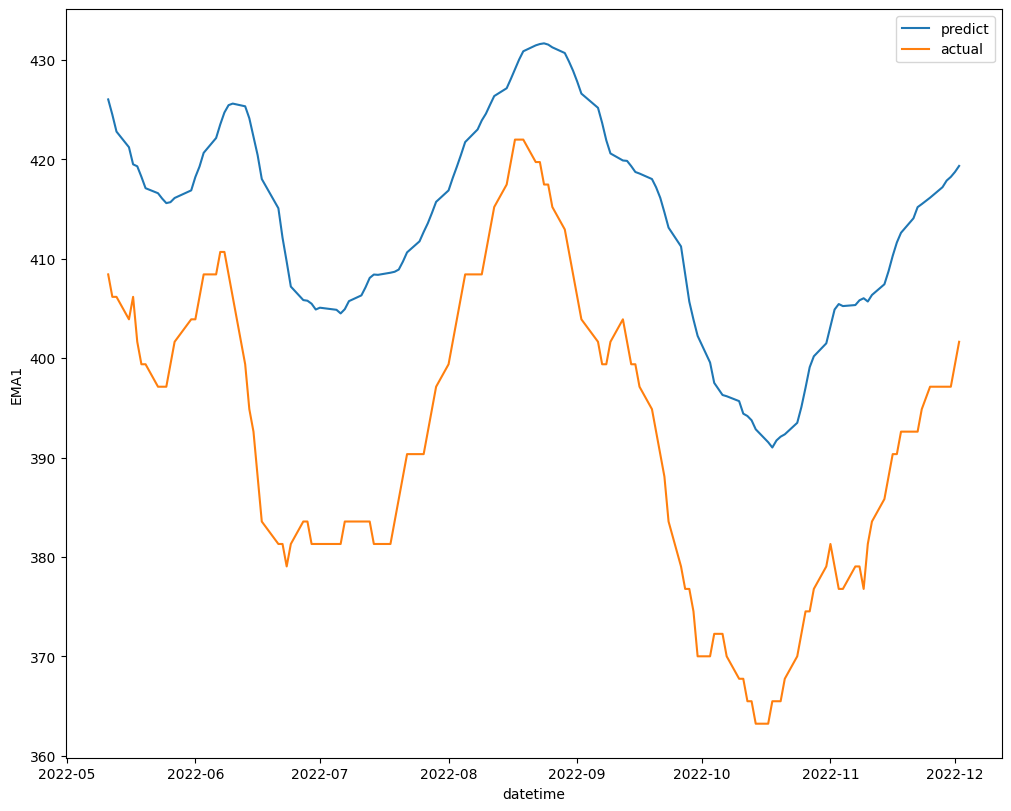

In [163]:

fig, ax = pyplot.subplots(figsize=(10, 8), layout='constrained')
ax.plot(dfPredict['PredVal'] ,label='predict')  # Plot some data on the axes.
ax.plot(dfPredict['ActualVal'],label='actual')  # Plot more data on the axes...

ax.set_xlabel('datetime')  # Add an x-label to the axes.
ax.set_ylabel(feature_cols[0])  # Add a y-label to the axes.
ax.legend();  # Add a legend.

In [165]:
# dx=dfPredict.loc['2022-01-01':,:]
# fig, ax = pyplot.subplots(figsize=(10, 8), layout='constrained')
# ax.plot(dx['PredVal'] ,label='predict')  # Plot some data on the axes.
# ax.plot(dx['ActualVal'],label='actual')  # Plot more data on the axes...

# ax.set_xlabel('datetime')  # Add an x-label to the axes.
# ax.set_ylabel('close price')  # Add a y-label to the axes.
# ax.legend();  # Add a legend.